<a href="https://colab.research.google.com/github/Eunjung-Cho/Project/blob/master/overwatch-league/%ED%81%B4%ED%94%8C_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

참고자료
https://bigdaheta.tistory.com/33

Base code는 위스콘신 유방암 예측 모델 코드

Dataset은 와인 데이터셋으로 아래 작성된 예제는 와인의 화학 조성을 사용하여 와인의 종류를 가장 잘 예측하는 모델을 찾는다.

# 기본 패키지 설정

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import collections
import pandas as pd
from sklearn import datasets

from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier # 결정 트리
from sklearn.neighbors import KNeighborsClassifier # KNN
from sklearn.linear_model import LogisticRegression # 로지스틱 회귀

from sklearn.ensemble import VotingClassifier,RandomForestClassifier,AdaBoostClassifier # 앙상블 

from sklearn.metrics import confusion_matrix, classification_report # 정오분류표
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score 
from sklearn.metrics import roc_curve, auc, roc_auc_score  # ROC곡선 그리기

from sklearn.model_selection import learning_curve, validation_curve # 학습곡선, 검증곡선
from sklearn.model_selection import GridSearchCV, cross_val_score  # 하이퍼파라미터 튜닝, 교차타당도

# 데이터 읽기

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df1 = pd.read_csv('e-sprot_data.csv')

In [ ]:
X = df1.drop(['target'],axis=1)
y = df1['target']

In [ ]:
df1.shape

(3632, 7)

In [ ]:
df1.head()

,diff_att_pdistance,diff_def_pdistance,diff_att_time_b,diff_def_time_b,diff_att_control_p,diff_def_control_p,target
0,0.034546,-75.615051,125.750572,240.000000,0.0,0.0,1
1,0.000000,0.000000,11.693085,-224.587952,0.0,0.0,1
2,0.000000,0.000000,0.000000,0.000000,0.0,-165.0,1
3,0.014160,-75.549507,165.840027,0.000000,0.0,0.0,1
4,0.017067,-70.161865,186.312805,240.000000,0.0,0.0,1


In [ ]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3632 entries, 0 to 3631
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   diff_att_pdistance  3632 non-null   float64
 1   diff_def_pdistance  3632 non-null   float64
 2   diff_att_time_b     3632 non-null   float64
 3   diff_def_time_b     3632 non-null   float64
 4   diff_att_control_p  3632 non-null   float64
 5   diff_def_control_p  3632 non-null   float64
 6   target              3632 non-null   int64  
dtypes: float64(6), int64(1)
memory usage: 198.8 KB


# 전처리 및 데이터 분할

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder() # 범주형 변수를 0부터 시작하는 정수형 숫자로 변환
y = le.fit_transform(y)


In [ ]:
y

array([1, 1, 1, ..., 0, 0, 0])

## train data , test data split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=1234, stratify=y)

# 모델

##  voting

logistic(로지스틱 회귀분석), tree(의사결정나무), knn(k-최근접 이웃)에 대한 모델링을 시행한다. 보팅 유형에는 예측한 결괏값 중 다수의 분류기가 결정한 예측값을 최종 보팅 결괏값으로 선정하는 하드 보팅(Hard Voting)과 분류기들의 레이블 값 결정 확률을 모두 더하여 이를 평균 내어 확률 값이 가장 높은 레이블을 최종 보팅 결괏값으로 선정하는 소프트 보팅(Soft Voting)이 있다. (일반적으로소프트 보팅 방법이 적용된다.)


In [ ]:
logistic = LogisticRegression(solver='liblinear',penalty='l2',C=100,random_state=1)
tree = DecisionTreeClassifier(max_depth=1,criterion='entropy',random_state=1)
knn = KNeighborsClassifier(n_neighbors=1,p=2,metric='minkowski')

voting_estimators = [('logistic', logistic), ('tree', tree), ('knn', knn)]

voting = VotingClassifier(estimators = voting_estimators,voting='soft')

clf_labels = ['Logistic regression', 'Decision tree', 'KNN', 'Majority voting']

all_clf = [logistic, tree, knn, voting]

### AUC 검정

In [ ]:
for clf, label in zip(all_clf, clf_labels):
  scores = cross_val_score(estimator=clf,X=X_train,y=y_train,cv=10,scoring='roc_auc')
  print("ROC AUC: %0.3f (+/- %0.3f) [%s]"
  % (scores.mean(), scores.std(), label))

ROC AUC: 0.899 (+/- 0.023) [Logistic regression]
ROC AUC: 0.755 (+/- 0.032) [Decision tree]
ROC AUC: 0.907 (+/- 0.022) [KNN]
ROC AUC: 0.943 (+/- 0.022) [Majority voting]


### ROC 커브

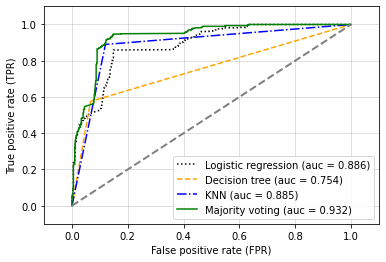

In [ ]:
colors = ['black', 'orange', 'blue', 'green']
linestyles = [':', '--', '-.', '-']
for clf, label, clr, ls \
        in zip(all_clf, clf_labels, colors, linestyles):

  clf.fit(X_train, y_train)
  y_pred = clf.predict_proba(X_test)[:, 1]
  fpr, tpr, thresholds = roc_curve(y_true=y_test,
                                  y_score=y_pred)
  roc_auc = auc(x=fpr, y=tpr) # 교차검증 X
  plt.plot(fpr, tpr,
            color=clr,
            linestyle=ls,
            label='%s (auc = %0.3f)' % (label, roc_auc))
  
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1],
          linestyle='--',
          color='gray',
          linewidth=2)

plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(alpha=0.5)
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')

plt.show()

### 정오 분류표로 검정

In [ ]:
voting.fit(X_train, y_train)
y_pred = voting.predict(X_test)

print('잘못 분류된 샘플 개수: %d' % (y_test != y_pred).sum())
print('정확도: %.3f' % accuracy_score(y_test, y_pred))
print('정밀도: %.3f' % precision_score(y_true=y_test, y_pred=y_pred))
print('재현율: %.3f' % recall_score(y_true=y_test, y_pred=y_pred))
print('F1: %.3f' % f1_score(y_true=y_test, y_pred=y_pred))

잘못 분류된 샘플 개수: 119
정확도: 0.891
정밀도: 0.849
재현율: 0.920
F1: 0.883


## Bagging

In [ ]:
tree = DecisionTreeClassifier(max_depth=None,criterion='entropy',random_state=1)

forest = RandomForestClassifier(criterion='entropy',n_estimators=500,random_state=1)

clf_labels = ['Decision tree', 'Random forest']

all_clf = [tree, forest]

### AUC 검정

In [ ]:
for clf, label in zip(all_clf, clf_labels):
  scores = cross_val_score(estimator=clf,X=X_train,y=y_train,cv=10,scoring='roc_auc') # 10 cv 결과 
  print("ROC AUC: %0.3f (+/- %0.3f) [%s]"
  % (scores.mean(), scores.std(), label))

ROC AUC: 0.936 (+/- 0.010) [Decision tree]
ROC AUC: 0.983 (+/- 0.006) [Random forest]


### ROC 커브

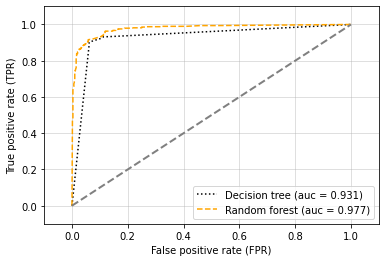

In [ ]:
colors = ['black', 'orange']
linestyles = [':', '--']
for clf, label, clr, ls \
        in zip(all_clf, clf_labels, colors, linestyles):

  clf.fit(X_train, y_train)
  y_pred = clf.predict_proba(X_test)[:, 1]
  fpr, tpr, thresholds = roc_curve(y_true=y_test,
                                  y_score=y_pred)
  roc_auc = auc(x=fpr, y=tpr)
  plt.plot(fpr, tpr,
            color=clr,
            linestyle=ls,
            label='%s (auc = %0.3f)' % (label, roc_auc))
  
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1],
          linestyle='--',
          color='gray',
          linewidth=2)

plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(alpha=0.5)
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')

plt.show()

### 정오분류표로 검정

In [ ]:
forest.fit(X_train, y_train)

y_pred = forest.predict(X_test)

print('잘못 분류된 샘플 개수: %d' % (y_test != y_pred).sum())
print('정확도: %.3f' % accuracy_score(y_test, y_pred))
print('정밀도: %.3f' % precision_score(y_true=y_test, y_pred=y_pred))
print('재현율: %.3f' % recall_score(y_true=y_test, y_pred=y_pred))
print('F1: %.3f' % f1_score(y_true=y_test, y_pred=y_pred))


잘못 분류된 샘플 개수: 80
정확도: 0.927
정밀도: 0.929
재현율: 0.906
F1: 0.917


## Boosting - ADABOOST

의사결정나무와 AdaBoost 기법을 이용하여 모델을 구축

In [ ]:
tree = DecisionTreeClassifier(max_depth=1, 
                              criterion='entropy',
                                random_state=1)

adaboost = AdaBoostClassifier(base_estimator=tree, 
                                n_estimators=700,
                                learning_rate = 0.01, 
                                random_state=1)

clf_labels = ['Decision tree', 'Ada boost']

all_clf = [tree, adaboost]

###  AUC 검정

In [ ]:
for clf, label in zip(all_clf, clf_labels):
  scores = cross_val_score(estimator=clf,X=X_train,y=y_train,cv=10,scoring='roc_auc')
  print("ROC AUC: %0.3f (+/- %0.3f) [%s]"
  % (scores.mean(), scores.std(), label))


ROC AUC: 0.755 (+/- 0.032) [Decision tree]
ROC AUC: 0.948 (+/- 0.017) [Ada boost]


### ROC 커브

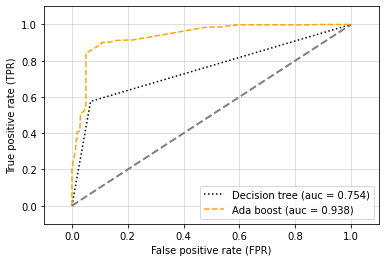

In [ ]:
colors = ['black', 'orange']
linestyles = [':', '--']
for clf, label, clr, ls \
        in zip(all_clf, clf_labels, colors, linestyles):

  clf.fit(X_train, y_train)
  y_pred = clf.predict_proba(X_test)[:, 1]
  fpr, tpr, thresholds = roc_curve(y_true=y_test,
                                  y_score=y_pred)
  roc_auc = auc(x=fpr, y=tpr)
  plt.plot(fpr, tpr,
            color=clr,
            linestyle=ls,
            label='%s (auc = %0.3f)' % (label, roc_auc))
  
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1],
          linestyle='--',
          color='gray',
          linewidth=2)

plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(alpha=0.5)
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')

plt.show()

### 정오 분류표로 검정

In [ ]:
adaboost.fit(X_train, y_train)
y_pred = adaboost.predict(X_test)

print('잘못 분류된 샘플 개수: %d' % (y_test != y_pred).sum())
print('정확도: %.3f' % accuracy_score(y_test, y_pred))
print('정밀도: %.3f' % precision_score(y_true=y_test, y_pred=y_pred))
print('재현율: %.3f' % recall_score(y_true=y_test, y_pred=y_pred))
print('F1: %.3f' % f1_score(y_true=y_test, y_pred=y_pred))

잘못 분류된 샘플 개수: 113
정확도: 0.896
정밀도: 0.875
재현율: 0.898
F1: 0.886
